<a href="https://colab.research.google.com/github/srivatsan1991/ML_Exercises/blob/master/cifar10svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIFAR-10 classification with a linear classifier and SVM loss from scratch:**
In this notebook we build a linear classifier using the SVM loss function and stochastic gradient descent. The code is implemented from scratch using numpy with fully vectorized implementation of the loss function and gradient computation. We then do hyperparameter tuning to get the best linear classifier model on this data. We find that the best linear model performs with an accuracy of about 39%, which is not much. This exercise is meant to set the stage for the need for non-linear classifiers with non-convex optimization for good performance on real-world models. 

The structure of the notebook closely follows the Stanford courses cs231n's assignment on this topic.

In [2]:
from tensorflow.keras.datasets.cifar10 import load_data
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules; see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
# clean up variables to prevent loading multiple times
try:
   del X_train, y_train
   del X_test, y_test
   print('Cleared previously loaded data.')
except:
   pass

(X_train, y_train), (X_test, y_test) = load_data()
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

# print data shapes as a sanity check
print('Training data shape:   ', X_train.shape)
print('Training labels shape: ',y_train.shape)
print('Testing data shape:    ', X_test.shape)
print('Testing labels shape:  ',y_test.shape)

Training data shape:    (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Testing data shape:     (10000, 32, 32, 3)
Testing labels shape:   (10000, 1)


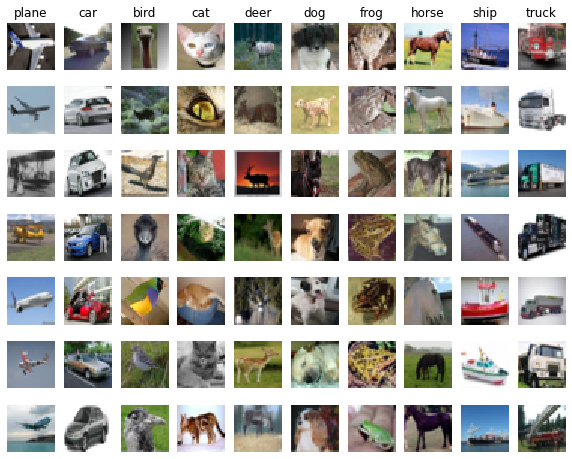

In [4]:
# Visualize some examples from the dataset, to make sure the data is what it should be:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# Data preprocessing:


*   We split the training data of 50000 images into a training set of 49000 and a validation set of 1000 images.
*   We the flatten each image from dimensions 32x32x3 to a 1d array of length 3072.
*   We then subtract the mean image.

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000, 1)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000, 1)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000, 1)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


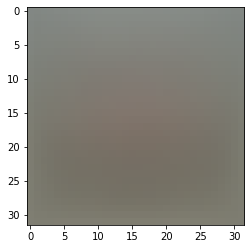

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

# SVM Loss and Gradient:

In this section we compute the loss function and gradient from scratch using fully vectorized numpy code for optimal performance. We remind the reader that the SVM loss for the $i$th image is given by:
$$ L_i = \sum_{q \neq y_i} max(0, s_q - s_{y_i} + \Delta) $$ 
where $s_q$ is the ``score'' assigned by the linear classifier for the $i$th image and $q$ th class.  The total loss is a sum of the average SVM loss (over all images) + the regularization loss, whose magnitude is controlled by the regularization strength $\lambda$.

$\Delta$ is a hyperparameter that can be safely set to equal $1.0$ as long as we correctly do hyperparameter tuning for $\lambda$. This is because, both $\lambda$ and $\Delta$ essentially play the role of controlling the magnitude of the weight matrix $W$  used in computing the scores $s_q$. Thus it is sufficient to tune for one of these two parameters.



In [8]:
def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.
    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength (referred to as $\lambda$ above)

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    num_train = X.shape[0]
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero

    scores = np.dot(X, W)
    correct_scores = np.array([scores[I, y[I]] for I in range(num_train)]).reshape((num_train,1)) # scores of the correct class

    lm = scores - correct_scores + 1.0  # a matrix of loss values where the positive entries need to be summed, Delta=1.0 as argued earlier

    # a bit mask for the locations with positive values
    mask = np.array(lm)
    mask[mask > 0] = 1
    mask[mask < 0] = 0

    # a bit mask where location (i,q) is =1.0 iff y[i]=q
    correct_mask = np.zeros(lm.shape)
    for I in range(num_train):
        correct_mask[I,y[I]] = 1
    
    # set the negative elements to zero in the loss matrix
    lm[lm < 0] = 0
    loss = (np.sum(lm)/num_train) - 1.0  # the subtraction of 1.0 is for the diagonal elements of lm
    
    dW += np.dot(np.transpose(X), mask)/num_train
    dW -= np.dot(np.multiply(np.transpose(X), np.sum(mask, axis=1)), correct_mask)/num_train

    dW += 2 * reg * W   # don't forget the regularization loss!

    return loss, dW

# Stochastic Gradient Descent

The goal is to start with a random weight matrix $W$ and train using stochastic gradient descent for a number of steps until equilibrium is achieved for the loss. We will visualize the loss as a function of the number of gradient descent steps, to see that indeed the weight matrix $W$ has equilibrated.

In [9]:
class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            # choose a random sample of size batch_size
            batch_mask = np.random.choice(num_train, batch_size)
            X_batch = X[batch_mask,:]
            y_batch = y[batch_mask]
            
            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # Update the weights using the gradient and the learning rate.          #
            self.W -= learning_rate*grad

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.argmax(np.dot(X, self.W), axis=1)

        return y_pred


class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)


In [10]:
import time
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 22.286720
iteration 100 / 1500: loss 7.215283
iteration 200 / 1500: loss 5.909575
iteration 300 / 1500: loss 5.002057
iteration 400 / 1500: loss 5.240038
iteration 500 / 1500: loss 4.635590
iteration 600 / 1500: loss 5.091443
iteration 700 / 1500: loss 4.663628
iteration 800 / 1500: loss 5.125014
iteration 900 / 1500: loss 5.014219
iteration 1000 / 1500: loss 4.877275
iteration 1100 / 1500: loss 5.283148
iteration 1200 / 1500: loss 5.066602
iteration 1300 / 1500: loss 4.662461
iteration 1400 / 1500: loss 4.888027
That took 13.042200s


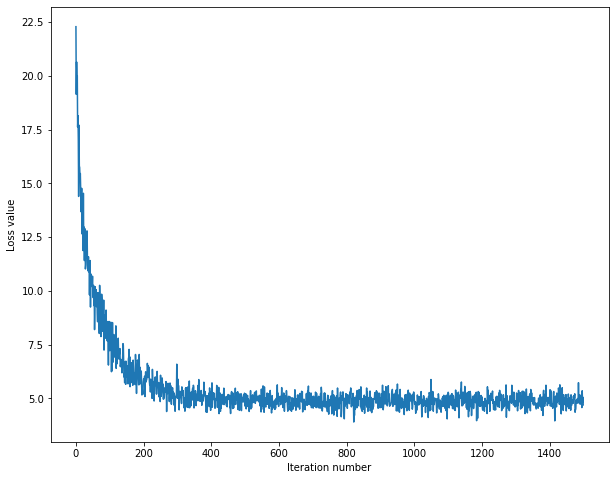

In [13]:
# We plot the loss as a function of iteration number
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [18]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train.reshape(-1) == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val.reshape(-1) == y_val_pred), ))

training accuracy: 0.369184
validation accuracy: 0.378000


# Hyperparameter tuning via cross-validation:

We sweep through choices of the two hyperparameters (`learning_rate` and `reg`) and test the accuracy on the validation set `X_val, y_val`. Note that the validation set is chosen to be distinct from both the training set and the test set. As we see from the loss history above, we need not go up to $1500$ iterations; we can instead use just $1000$ iterations. This will speed things up considerably.



In [22]:
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

# We need to play with choices of these hyperparameters
learning_rates = [1e-7,  46e-8, 4e-8]
regularization_strengths = [2.5e4, 3e4, 3.5e4]

for lr in learning_rates:
    for rg in regularization_strengths:
        current_svm = LinearSVM()
        loss_hist = current_svm.train(X_train, y_train, learning_rate=lr, reg=rg,
                      num_iters=1000, verbose=False)
        
        y_train_pred = current_svm.predict(X_train)
        train_acc = (np.mean(y_train.reshape(-1) == y_train_pred))
        y_val_pred = current_svm.predict(X_val)
        val_acc = (np.mean(y_val.reshape(-1) == y_val_pred))
        results[(lr, rg)] = (train_acc, val_acc)

        if val_acc > best_val:
            best_val = val_acc
            best_svm = current_svm

    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 4.000000e-08 reg 2.500000e+04 train accuracy: 0.354367 val accuracy: 0.363000
lr 4.000000e-08 reg 3.000000e+04 train accuracy: 0.364204 val accuracy: 0.389000
lr 4.000000e-08 reg 3.500000e+04 train accuracy: 0.365490 val accuracy: 0.385000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.370857 val accuracy: 0.385000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.371102 val accuracy: 0.395000
lr 1.000000e-07 reg 3.500000e+04 train accuracy: 0.359837 val accuracy: 0.380000
lr 4.600000e-07 reg 2.500000e+04 train accuracy: 0.335755 val accuracy: 0.335000
lr 4.600000e-07 reg 3.000000e+04 train accuracy: 0.345571 val accuracy: 0.354000
lr 4.600000e-07 reg 3.500000e+04 train accuracy: 0.321265 val accuracy: 0.321000
best validation accuracy achieved during cross-validation: 0.395000


# We can visualize the cross-validation results using a scatter plot:

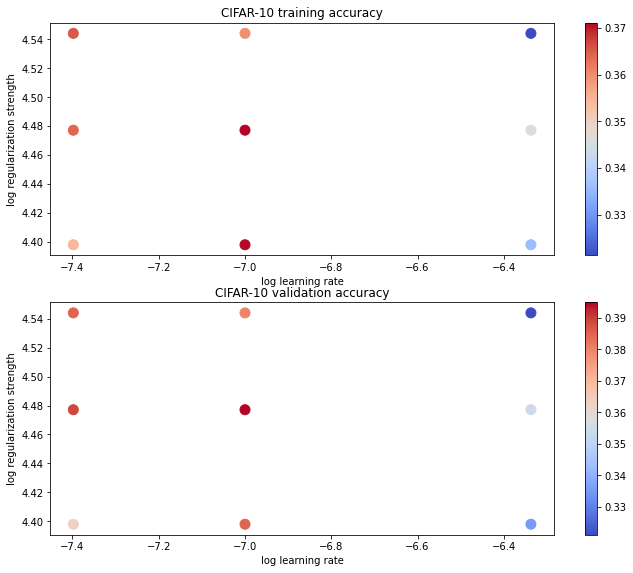

In [23]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

# Finally, Test Set Accuracy!:

In [24]:
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test.reshape(-1) == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.375000


#Visualizing the Weight matrix:
As a consequence of the fact that we are implementing a linear classifier, the rows of the images in fact look like composite image constructed from the training data corresponding to a particular class. We can visualize this as follows:
There are some funny features in the composite image, e.g., the composite image for horse looks like a two-headed horse with left and right facing heads. This indicates that the training data has a good number of both left facing horses and right facing horses.

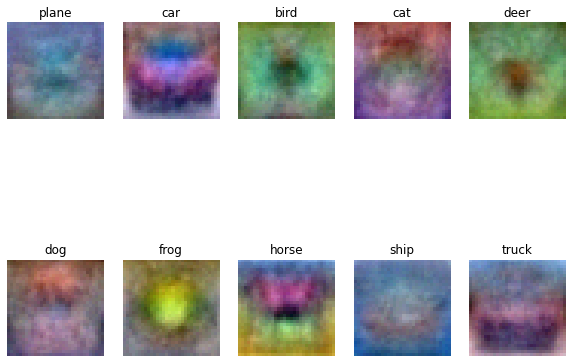

In [26]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])